# Automatic Hate Speech Corpus From Unannotated Data

In [ ]:
!pip3 install evaluate

In [4]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import sqlite3
import math

from datasets import Dataset, load_from_disk, DatasetDict

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from transformers import pipeline

from transformers import AutoModelForMaskedLM
from transformers import DataCollatorForLanguageModeling
from transformers import AdamW, get_scheduler

import torch
from torch import nn
import torch.nn.functional as F

import evaluate

from IPython.display import display, clear_output

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from matplotlib import pyplot as plt
%matplotlib inline

from metrics_wrapper import MetricsWrapper

from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve

import tikzplotlib

## Importing data

### Dev set

In [5]:
dev_set = load_from_disk("datasets/flashback_annotated_dev_set")
dev_set

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2585
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 647
    })
})

## Experimenting with how to define automatic annotation

### Pow-BoW ^-^

First import the tokenizer and tokenize all the data. Since `scikit`'s trainers desire the data be in strings, we need to then concatenate them together again. I just used spaces even though that results in strings like `krist ##na gå #r i Kyrk ##an`, since it is probably as close as I can get to how BERT later will handle them.

In [4]:
tokenizer = AutoTokenizer.from_pretrained("flashback_lm_model_larger_batch_size")

In [5]:
X_train = [tokenizer(x).tokens() for x in dev_set["train"]["text"]]
y_train = np.array(dev_set["train"]["label"])

X_test = np.array([' '.join(tokenizer(x).tokens()) for x in dev_set["test"]["text"]])
y_test = np.array(dev_set["test"]["label"])

Then we need to strip the strings from stopwords and punctuation. This is done automatically via the `scikit` pipeline, but we need to define them. I just ran through the pipeline a few times and manually added some tokenizer-specific stopwords/grammatical conjugations that in testing didn't affect performance but just added unwanted noise. I then concatenated those manually added with the stopword list from `NLTK`, which improved performance slightly.

In [6]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
fb_stopwords = set(
    [
        "[CLS]",
        "[SEP]",
        "och",
        "-",
        ".",
        ",",
        "så",
        "är",
        "en",
        "för",
        "när",
        "bla",
        "av",
        "blev",
        "!",
        "med",
        ", ",
        "##s",
        "cl",
        "sep",
        "#",
        "[', ']",
        "s",
        "'",
        ") (",
        "(",
        ")",
    ]
    + stopwords.words('swedish')
)

#### **BoW (i.e. CountVectorizer)**

##### BoW Hyper-Parameter Search

In [9]:
def bow_hyper_parameter_search(possible_c_values):
    conf_matrices = dict()
    f1_scores = dict()
    try:
        for idx, i in enumerate(possible_c_values):
            features_pipeline = make_pipeline(
            CountVectorizer(
                analyzer="word",
                tokenizer=lambda x: tokenizer(x).tokens(),
                stop_words=fb_stopwords
            ),
                LinearSVC(C=i)
            )

            features_pipeline.fit(dev_set["train"]["text"], dev_set["train"]["label"])
            y_pred = features_pipeline.predict(X_test)
            f1 = f1_score(y_test, y_pred)
            f1_scores[i] = f1
            conf_matrix = confusion_matrix(y_pred=y_pred, y_true=y_test)
            conf_matrices[i] = conf_matrix

            clear_output(wait=True)

            plt.figure(figsize=(10, 5))
            plt.title('C value search')
            plt.plot(possible_c_values[:idx+1], f1_scores.values())
            plt.scatter(possible_c_values[:idx+1], f1_scores.values())
            plt.xlabel('C')
            plt.ylabel('f1')
            display(plt.gcf())
            plt.close('all')

            print(conf_matrix)
    except KeyboardInterrupt:
        pass
    return (f1_scores, conf_matrices)

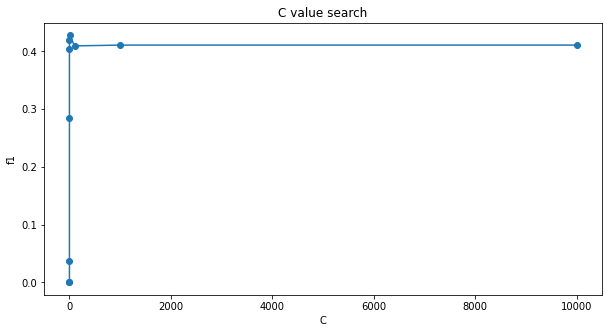

[[411  85]
 [ 90  61]]


In [10]:
f1_scores, conf_matrices = bow_hyper_parameter_search([10**i for i in range(-5,5)])

In [11]:
f1_scores

{1e-05: 0.0,
 0.0001: 0.0,
 0.001: 0.03726708074534162,
 0.01: 0.2843137254901961,
 0.1: 0.4044943820224719,
 1: 0.4192439862542955,
 10: 0.42763157894736836,
 100: 0.40939597315436244,
 1000: 0.4107744107744108,
 10000: 0.4107744107744108}

Performance seems to be best in the range between $1$ and $10$, so lets search for a more fine-grained value for $C$:

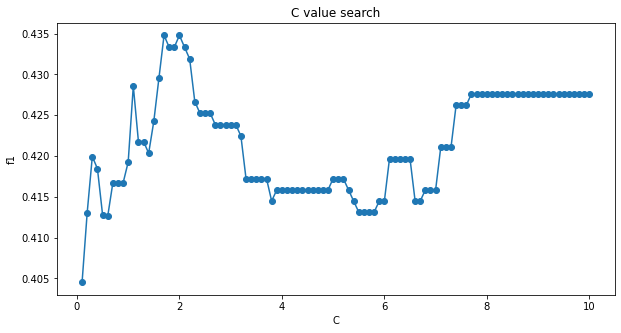

[[408  88]
 [ 86  65]]


In [12]:
f1_scores, conf_matrices = bow_hyper_parameter_search([x/10 for x in range(1, 101)])

In [15]:
dict(list(reversed(sorted(f1_scores.items(), key=lambda item: item[1])))[:10])

{2.0: 0.43478260869565216,
 1.7: 0.43478260869565216,
 2.1: 0.43333333333333335,
 1.9: 0.43333333333333335,
 1.8: 0.43333333333333335,
 2.2: 0.4318936877076412,
 1.6: 0.42953020134228187,
 1.1: 0.4285714285714286,
 10.0: 0.42763157894736836,
 9.9: 0.42763157894736836}

##### BoW Pipeline

In [16]:
bow_pipeline = make_pipeline(
    CountVectorizer(
        analyzer="word",
        tokenizer=lambda x: tokenizer(x).tokens(),
        stop_words=fb_stopwords
    ),
    LinearSVC(C=2)
)

bow_pipeline.fit(dev_set["train"]["text"], dev_set["train"]["label"])
bow_y_pred = bow_pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_pred=bow_y_pred, y_true=y_test)

print(f"f1: {f1_score(y_test, bow_y_pred)}")
print(f"confusion matrix:\n\t{conf_matrix[0]}\n\t{conf_matrix[1]}")

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['[', ']'] not in stop_words.
  warnings.warn(


f1: 0.43478260869565216
confusion matrix:
	[413  83]
	[86 65]


#### **TF-IDF**

##### TF-IDF Hyper-parameter search

In [17]:
def tf_idf_hyper_parameter_search(possible_c_values):
    conf_matrices = dict()
    f1_scores = dict()
    try:
        for idx, i in enumerate(possible_c_values):
            features_pipeline = make_pipeline(
                TfidfVectorizer(
                    analyzer="word",
                    ngram_range=(1, 6),
                    tokenizer=lambda x: tokenizer(x).tokens(),
                    stop_words=fb_stopwords
                ),
                LinearSVC(C=i)
            )

            features_pipeline.fit(dev_set["train"]["text"], dev_set["train"]["label"])
            y_pred = features_pipeline.predict(X_test)
            f1 = f1_score(y_test, y_pred)
            f1_scores[i] = f1
            conf_matrix = confusion_matrix(y_pred=y_pred, y_true=y_test)
            conf_matrices[i] = conf_matrix

            clear_output(wait=True)

            plt.figure(figsize=(10, 5))
            plt.title('C value search')
            plt.plot(possible_c_values[:idx+1], f1_scores.values())
            plt.scatter(possible_c_values[:idx+1], f1_scores.values())
            plt.xlabel('C')
            plt.ylabel('f1')
            display(plt.gcf())
            plt.close('all')

            print(conf_matrix)
    except KeyboardInterrupt:
        pass
    return (f1_scores, conf_matrices)

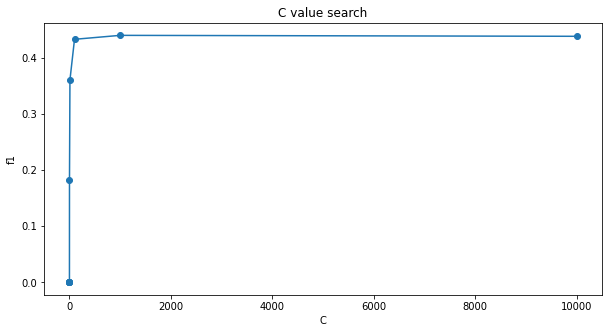

[[369 127]
 [ 73  78]]


In [18]:
f1_scores, conf_matrices = tf_idf_hyper_parameter_search([10**i for i in range(-5,5)])

In [19]:
f1_scores

{1e-05: 0.0,
 0.0001: 0.0,
 0.001: 0.0,
 0.01: 0.0,
 0.1: 0.0,
 1: 0.18181818181818182,
 10: 0.3605150214592274,
 100: 0.4328358208955224,
 1000: 0.4398826979472141,
 10000: 0.4382022471910112}

We see that the highest scores are from $10 \rightarrow 100$. I suspect that it plateaus around there, so lets perform a more fine grained search in that interval.

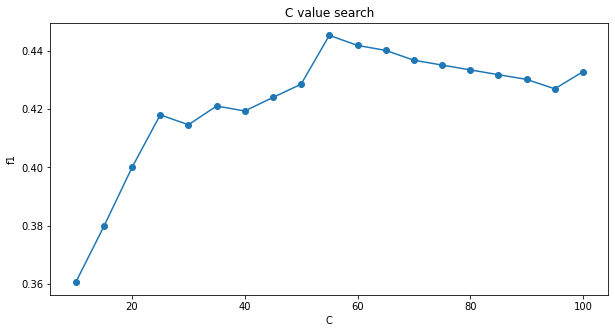

[[437  59]
 [ 93  58]]


In [20]:
f1_scores, conf_matrices = tf_idf_hyper_parameter_search([5 + x*5 for x in range(1, 20)])

In [22]:
dict(list(reversed(sorted(f1_scores.items(), key=lambda item: item[1])))[:10])

{55: 0.44531249999999994,
 60: 0.4418604651162791,
 65: 0.4401544401544401,
 70: 0.43678160919540227,
 75: 0.43511450381679384,
 80: 0.43346007604562736,
 100: 0.4328358208955224,
 85: 0.4318181818181818,
 90: 0.43018867924528303,
 50: 0.42857142857142855}

Let's do one last search, this time even more fine grained, in the interval $50 \rightarrow 75$

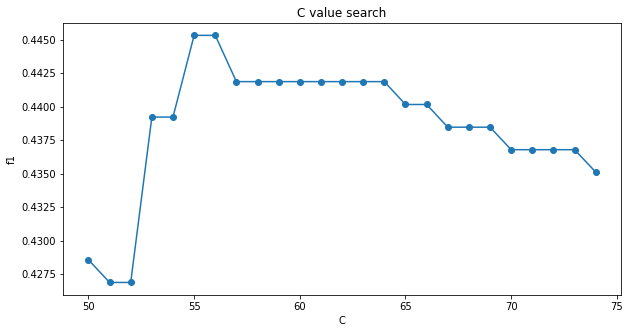

[[442  54]
 [ 94  57]]


In [24]:
f1_scores, conf_matrices = tf_idf_hyper_parameter_search([x for x in range(50, 75)])

In [25]:
dict(list(reversed(sorted(f1_scores.items(), key=lambda item: item[1])))[:10])

{56: 0.44531249999999994,
 55: 0.44531249999999994,
 64: 0.4418604651162791,
 63: 0.4418604651162791,
 62: 0.4418604651162791,
 61: 0.4418604651162791,
 60: 0.4418604651162791,
 59: 0.4418604651162791,
 58: 0.4418604651162791,
 57: 0.4418604651162791}

##### TF-IDF Pipeline

In [8]:
tfidf_pipeline = make_pipeline(
    TfidfVectorizer(
        analyzer="word",
        ngram_range=(1, 6),
        tokenizer=lambda x: tokenizer(x).tokens(),
        stop_words=fb_stopwords
    ),
    LinearSVC(C=55)
)

tfidf_pipeline.fit(dev_set["train"]["text"], dev_set["train"]["label"])
tfidf_pipeline_y_pred = tfidf_pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_pred=tfidf_pipeline_y_pred, y_true=y_test)

print(f"f1: {f1_score(y_test, tfidf_pipeline_y_pred)}")
print(f"confusion matrix:\n\t{conf_matrix[0]}\n\t{conf_matrix[1]}")
print(f"precision:\n\t{precision_score(y_test, tfidf_pipeline_y_pred)}")
print(f"recall:\n\t{recall_score(y_test, tfidf_pipeline_y_pred)}")

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['[', ']'] not in stop_words.
  warnings.warn(


f1: 0.44531249999999994
confusion matrix:
	[448  48]
	[94 57]
precision:
	0.5428571428571428
recall:
	0.37748344370860926


#### **Going through top features**

##### **TF-IDF**

In [9]:
features = tfidf_pipeline[0].get_feature_names_out()

for i in np.array(tfidf_pipeline._final_estimator.coef_[0]).argsort()[-25:][::-1]:
    print(features[i])

##a
##er
feminist
precis vill
##r
dom
vita
fan
##ar
##n
muslimer
nivå
paras
jävla
##k
andra
svenska
kvinnor
##are
sverige
##tte
##t
##aner
##ad
vill


In [10]:
conf_matrix = confusion_matrix(y_pred=tfidf_pipeline.predict(X_test), y_true=y_test)
conf_matrix

array([[448,  48],
       [ 94,  57]])

##### **BoW**

In [47]:
features = bow_pipeline[0].get_feature_names_out()

for i in np.array(bow_pipeline._final_estimator.coef_[0]).argsort()[-25:][::-1]:
    print(features[i])

nivå
brinna
tyst
skedde
svin
##iz
äger
paras
##iterna
tomte
##tte
##rass
dum
precis
gifter
mm
sänka
mkt
##pi
håll
smyg
bekräftar
##tavla
mum
kloka


In [48]:
conf_matrix = confusion_matrix(y_pred=bow_pipeline.predict(X_test), y_true=y_test)
conf_matrix

array([[413,  83],
       [ 86,  65]])

### Testset metrics

These are the calculations necessary to derive the metrics for the testset. These weren't performed until every part of the experimentation was done, meaning that I didn't use the testset to optimize hyperparameters for the SVM.

In [9]:
flashback_testset = pd.read_csv("datasets/flashback_annotated_data_test_set.tsv", sep="\t")
flashback_testset = Dataset.from_pandas(flashback_testset)
flashback_testset

Dataset({
    features: ['text', 'label'],
    num_rows: 808
})

In [10]:
flashback_testset_y_pred = tfidf_pipeline.predict(flashback_testset["text"])

In [11]:
conf_matrix = confusion_matrix(y_pred=flashback_testset_y_pred, y_true=flashback_testset['label'])
print(f"f1: {f1_score(flashback_testset['label'], flashback_testset_y_pred)}")
print(f"confusion matrix:\n\t{conf_matrix[0]}\n\t{conf_matrix[1]}")
print(f"precision:\n\t{precision_score(flashback_testset['label'], flashback_testset_y_pred)}")
print(f"recall:\n\t{recall_score(flashback_testset['label'], flashback_testset_y_pred)}")

f1: 0.4702702702702703
confusion matrix:
	[525  94]
	[102  87]
precision:
	0.48066298342541436
recall:
	0.4603174603174603


## Applying to large pool of unannotated data

### Importing unannotated data

Since we don't want our training set to have anything to do with our dev or test set, let's first import the test set, and then use a boolean slice to remove those rows from our large pool of unannotated data.

In [9]:
testset = Dataset.from_csv("datasets/flashback_annotated_data_test_set.tsv", sep="\t")
dev_test_text_arr = testset["text"] + dev_set["test"]["text"]

Using custom data configuration default-e3332014f9c6d905


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-e3332014f9c6d905/0.0.0. Subsequent calls will reuse this data.


In [ ]:
pool_df = pd.read_csv("data/flashback_raw.tsv", index_col=0, sep="\t")
pool_df = pool_df[~pool_df["text"].isin(dev_test_text_arr)]

This is too big to experiment on, however, so let's downsample it a bit:

In [ ]:
pool_df = pool_df.sample(frac = 1, random_state = 666).reset_index(drop=True) # shuffle dataframe
pool_df = pool_df[:20000]

In [ ]:
tmp_df = pool_df.copy()
pred = tfidf_pipeline.predict(tmp_df["text"].to_numpy())
tmp_df["label"] = pred

### Looking into proportion of HS/non-HS for automatically derived data

In [16]:
dev_df = tmp_df.copy()

In [41]:
def calc_proportion(df):
    counts = df["label"].value_counts()
    return round((counts[1] / len(df)), 5)


def split_dataset(df, hs):
    counts = df["label"].value_counts()
    total = counts[1]/hs
    if (total - counts[1]) < counts[0]: # drop rows from label 0
        desired_label = 0
        n = int(counts[0] - (total - counts[1]))
    else: # drop rows from label 1
        desired_label = 1
        n = int(counts[1] - ((counts[0]/(1-hs)) - counts[0]))     
    df = df.drop(df.loc[df['label'] == desired_label].head(n).index).reset_index(drop=True)
    print(f"{calc_proportion(df)}% HS")
    print(df["label"].value_counts())
    return df

In [98]:
tmp_df = split_dataset(dev_df, 0.33)

0.33% HS
0    25298
1    12460
Name: label, dtype: int64


### Training BERT using automatically annotated data

In [13]:
tmp_dataset = DatasetDict({
    "train": Dataset.from_pandas(tmp_df),
    "test": dev_set["test"]
})
tmp_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 647
    })
})

### Training model

In [14]:
configuration = AutoConfig.from_pretrained("flashback_lm_model_larger_batch_size")
configuration.hidden_dropout_prob = 0.2
configuration.attention_probs_dropout_prob = 0.2
masked_lm_checkpoint = AutoModelForSequenceClassification.from_pretrained(
    "flashback_lm_model_larger_batch_size",
    config=configuration
)
tokenizer = AutoTokenizer.from_pretrained("flashback_lm_model_larger_batch_size")
tokenizer.model_max_length = 512  # since this is incorrectly set in KB's model

configuration

Some weights of the model checkpoint at flashback_lm_model_larger_batch_size were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at flashbac

BertConfig {
  "_name_or_path": "flashback_lm_model_larger_batch_size",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.2,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50325
}

In [15]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = tmp_dataset.map(tokenize_function, batched=True)
tokenized_datasets

Parameter 'function'=<function tokenize_function at 0x7fadec4b2af0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 647
    })
})

In [16]:
batch_size = 16
# Show the training loss with every epoch
logging_steps = len(tmp_dataset["train"]) // batch_size
model_name = "bert-base-swedish-cased"
metric = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-automatic-classification-flashback",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    weight_decay=0.0005,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    eval_accumulation_steps=1,  # slower, but less prone to overflow CUDA memory
    num_train_epochs=3,
    logging_steps=logging_steps,
    save_strategy="no",  # I don't need to save model checkpoints when running experiments
)

trainer = Trainer(
    model=masked_lm_checkpoint,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [17]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3750


Epoch,Training Loss,Validation Loss,F1
1,0.358400,0.641744,0.470199
2,0.271300,0.726082,0.483660
3,0.225500,0.899769,0.480480


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 647
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 647
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 647
  Batch size = 16


Training compl

TrainOutput(global_step=3750, training_loss=0.28504336751302084, metrics={'train_runtime': 2738.9358, 'train_samples_per_second': 21.906, 'train_steps_per_second': 1.369, 'total_flos': 1.57866633216e+16, 'train_loss': 0.28504336751302084, 'epoch': 3.0})

And then, if the results are deemed worthy, let's save it for future inference and the domain transfer task.

In [23]:
trainer.save_model("flashback_automatic_model")

Saving model checkpoint to flashback_automatic_model
Configuration saved in flashback_automatic_model/config.json
Model weights saved in flashback_automatic_model/pytorch_model.bin
tokenizer config file saved in flashback_automatic_model/tokenizer_config.json
Special tokens file saved in flashback_automatic_model/special_tokens_map.json


### Evaluating model

We do the same as we did for the annotated version, first defining a pipeline, and then using the `MetricsWrapper` class to evaluate the model (which is, as the name implies, a simple class written to make getting various metrics easy).

In [24]:
automatic_model_pipeline = pipeline(
    "text-classification",
    model="flashback_automatic_model",
)

loading configuration file flashback_automatic_model/config.json
Model config BertConfig {
  "_name_or_path": "flashback_automatic_model",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.2,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50325
}

loading configuration file flashback_automatic_model/config.json
Model config BertConfig {
  "_name_or_path": "flashback_automatic_model",
  "architectu

#### Devset

In [25]:
dev_metrics = MetricsWrapper(automatic_model_pipeline, dev_set["test"])

No change in proportion HS/non-HS:

precision: 0.44
recall: 0.53
f1_score: 0.48


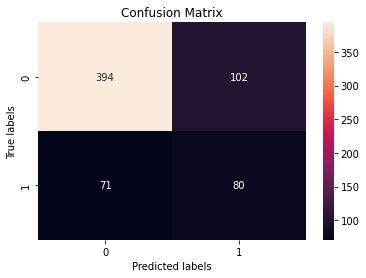

In [26]:
dev_metrics.display_metrics()

50% HS/non-HS:

precision: 0.40
recall: 0.60
f1_score: 0.48


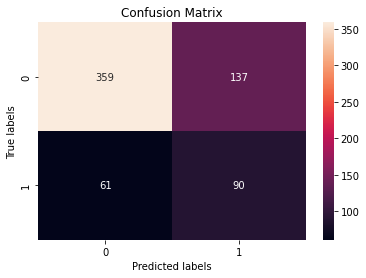

In [59]:
dev_metrics.display_metrics()

33% HS/non-HS

precision: 0.47
recall: 0.51
f1_score: 0.49


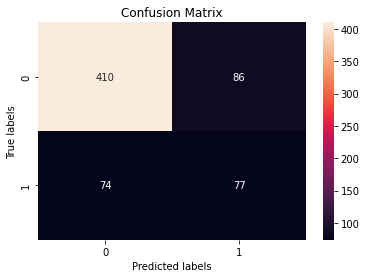

In [107]:
dev_metrics.display_metrics()

25% HS/non-HS:

precision: 0.49
recall: 0.47
f1_score: 0.48


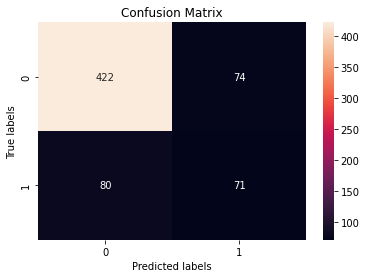

In [90]:
dev_metrics.display_metrics()

## Cross-domain transfer

### Training MLM

#### Import data

In [3]:
tokenizer = AutoTokenizer.from_pretrained('KB/bert-base-swedish-cased')
tokenizer.model_max_length = 512
model_checkpoint = AutoModelForMaskedLM.from_pretrained('KB/bert-base-swedish-cased')

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/390k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

In [4]:
conn = sqlite3.connect("data/familjeliv.db")
with conn:
    pool_df = pd.read_sql_query("SELECT * FROM posts;", conn, index_col="id")
    pool_df = pool_df.sample(frac = 1, random_state = 666).reset_index(drop=True)
    pool_df["label"] = 0
    pool_df = pool_df[["text", "label"]]

mlm_dataset = DatasetDict({
    "train": Dataset.from_pandas(pool_df[:100000].reset_index(drop=True)),
    "test": Dataset.from_pandas(pool_df[100000:110000].reset_index(drop=True))
})

mlm_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 10000
    })
})

#### Convert dataset to chunks

In [5]:
def tokenize_function(document):
    """ returns tokenized document, quickly if tokenizer 'is fast' according to hf"""
    result = tokenizer(document["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

In [6]:
chunk_size = tokenizer.model_max_length

In [7]:
tokenized_datasets = mlm_dataset.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets

Parameter 'function'=<function tokenize_function at 0x7fd1a7ac3b80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/100 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1033 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/10 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 10000
    })
})

In [8]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [9]:
mlm_dataset = tokenized_datasets.map(group_texts, batched=True)
mlm_dataset

  0%|          | 0/100 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 14803
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 1441
    })
})

#### Train MLM

In [10]:
batch_size = 12
# Show the training loss with every epoch
logging_steps = len(mlm_dataset["train"]) // batch_size
model_name = "bert-base-swedish-cased"

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-familjeliv-automatic",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    eval_accumulation_steps=1,  # slower, but less prone to overflow CUDA memory
    num_train_epochs=15,
    save_strategy="no",  # not necessary here
    logging_steps=logging_steps,
)

trainer = Trainer(
    model=model_checkpoint,
    args=training_args,
    train_dataset=mlm_dataset["train"],
    eval_dataset=mlm_dataset["test"],
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15),
    tokenizer=tokenizer,
)

First, let's measure the perplexity before MLM finetuning:

In [11]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1441
  Batch size = 12


>>> Perplexity: 25.19


And then, finally, let's finetune:

In [12]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14803
  Num Epochs = 15
  Instantaneous batch size per device = 12
  Total train batch size (w. parallel, distributed & accumulation) = 12
  Gradient Accumulation steps = 1
  Total optimization steps = 18510


Epoch,Training Loss,Validation Loss
1,2.200300,1.988014
2,2.089100,1.934753
3,2.036500,1.928752
4,1.998500,1.910472
5,1.970600,1.866040
6,1.939200,1.868417
7,1.918000,1.857639
8,1.898200,1.846216
9,1.888200,1.838615
10,1.875200,1.839156


The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1441
  Batch size = 12
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1441
  Batch size = 12
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1441
  Batch size = 12
The following columns in the evaluation set don't have a corresponding ar

TrainOutput(global_step=18510, training_loss=1.9354288089861424, metrics={'train_runtime': 13773.1725, 'train_samples_per_second': 16.122, 'train_steps_per_second': 1.344, 'total_flos': 5.845682072489472e+16, 'train_loss': 1.9354288089861424, 'epoch': 15.0})

And then, let's check how well it learned domain-specific lingo:

In [13]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1441
  Batch size = 12


>>> Perplexity: 6.16


And then, to save results:

In [14]:
trainer.save_model("familjeliv_mlm_automatic")

Saving model checkpoint to familjeliv_mlm_automatic
Configuration saved in familjeliv_mlm_automatic/config.json
Model weights saved in familjeliv_mlm_automatic/pytorch_model.bin
tokenizer config file saved in familjeliv_mlm_automatic/tokenizer_config.json
Special tokens file saved in familjeliv_mlm_automatic/special_tokens_map.json


### Using model from previous domain to annotate data from new domain

#### Creating new SVM classifier 

First we need to import the model, and use that for inference on the new data, in order to create a new "golden standard":

In [8]:
tokenizer = AutoTokenizer.from_pretrained("flashback_automatic_model")
automatic_model_pipeline = pipeline(
    "text-classification",
    model="flashback_automatic_model",
)

Then we import the unannotated data from familjeliv, as well as the test set (to make sure that they don't find themselves into the training data):

In [9]:
conn = sqlite3.connect("data/familjeliv.db")
with conn:
    familjeliv_df = pd.read_sql_query("SELECT * FROM posts;", conn, index_col="id")

# import the testset
familjeliv_testset = DatasetDict.load_from_disk("datasets/familjeliv_annotated_dataset")

# remove posts which also exist in the testset
familjeliv_df = familjeliv_df[~familjeliv_df["text"].isin(familjeliv_testset["test"]["text"])]
familjeliv_df["label"] = 0  # default to 0
familjeliv_df = familjeliv_df[["text", "label"]]

# shuffle dataset according to random seed and crop
familjeliv_df = familjeliv_df.sample(frac = 1, random_state = 666).reset_index(drop=True) # shuffle dataframe
familjeliv_df = familjeliv_df[:20000]

In [33]:
%%time
tokenizer_kwargs = {'padding':True, 'truncation':True, 'max_length':512}
tmp_model_predictions = automatic_model_pipeline(list(familjeliv_df["text"]), **tokenizer_kwargs)

CPU times: user 2h 23min 39s, sys: 0 ns, total: 2h 23min 39s
Wall time: 24min 1s


Since inference takes a while, let's save it so that we don't have to do it again after restarting the kernel:

In [34]:
import pickle

with open("datasets/familjeliv_20000_inference.pkl", "wb") as f:
    pickle.dump(tmp_model_predictions, f)

And a cell for importing:

In [10]:
import pickle

with open("datasets/familjeliv_20000_inference.pkl", "rb") as f:
    tmp_model_predictions = pickle.load(f)

In [11]:
tmp_model_predictions = [0 if x["label"] == "LABEL_0" else 1 for x in tmp_model_predictions]

In [12]:
familjeliv_df["label"] = tmp_model_predictions

train_size = int(len(familjeliv_df) * 0.8)
familjeliv_devset = DatasetDict({
    "train": Dataset.from_pandas(familjeliv_df[:train_size].reset_index(drop=True)),
    "test": Dataset.from_pandas(familjeliv_df[train_size:].reset_index(drop=True))
})
familjeliv_devset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 4000
    })
})

NB. The training data here is all automatically derived.

In [13]:
tfidf_pipeline = make_pipeline(
    TfidfVectorizer(
        analyzer="word",
        ngram_range=(1, 6),
        tokenizer=lambda x: tokenizer(x).tokens(),
        stop_words=fb_stopwords
    ),
    LinearSVC(C=55)
)

tfidf_pipeline.fit(familjeliv_devset["train"]["text"], familjeliv_devset["train"]["label"])

features = tfidf_pipeline[0].get_feature_names_out()

for i in np.array(tfidf_pipeline._final_estimator.coef_[0]).argsort()[-25:][::-1]:
    print(features[i])

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['[', ']'] not in stop_words.
  warnings.warn(


muslimer
dom
##a
islam
feminist
##er
feminist ##er
kvinnor
män
##ar
muslimska
femin
bara
##r
fan
sverige
folk
andra
##t
vita
våld
##e
kommer
##fem
judar


#### Precision/recall curves

Display precision/recall curves for different thresholds in the SVM classifier

In [14]:
familjeliv_testset = DatasetDict.load_from_disk("datasets/familjeliv_testset")["test"]
X, y_true = familjeliv_testset["text"], familjeliv_testset["label"]

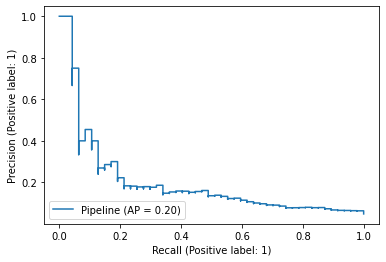

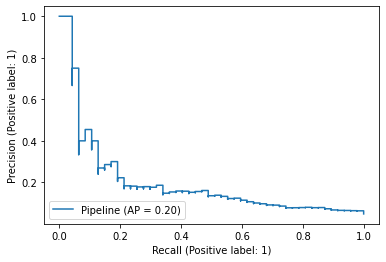

In [18]:
pRDisp = PrecisionRecallDisplay.from_estimator(tfidf_pipeline, X, y_true).plot()
tikzplotlib.save("test.tex")

#### Automatically labelling DF

In [39]:
tmp_df = familjeliv_df.copy()
pred = tfidf_pipeline.predict(tmp_df["text"].to_numpy())
tmp_df["label"] = pred

In [42]:
f"{calc_proportion(tmp_df) * 100:.2f}% HS"

'17.68% HS'

In [43]:
tmp_df["label"].value_counts()

0    16464
1     3536
Name: label, dtype: int64

In [44]:
training_size = int(0.8 * len(tmp_df))
tmp_dataset = DatasetDict({
    "train": Dataset.from_pandas(tmp_df[:training_size]),
    "test": Dataset.from_pandas(tmp_df[training_size:])
})
tmp_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 4000
    })
})

### Testset metrics for SVM classifier

In [45]:
familjeliv_testset = DatasetDict.load_from_disk("datasets/familjeliv_testset")["test"]
familjeliv_testset

Dataset({
    features: ['text', 'label'],
    num_rows: 978
})

In [46]:
familjeliv_testset_y_pred = tfidf_pipeline.predict(familjeliv_testset["text"])

In [47]:
conf_matrix = confusion_matrix(y_pred=familjeliv_testset_y_pred, y_true=familjeliv_testset['label'])
print(f"f1: {f1_score(familjeliv_testset['label'], familjeliv_testset_y_pred)}")
print(f"confusion matrix:\n\t{conf_matrix[0]}\n\t{conf_matrix[1]}")
print(f"precision:\n\t{precision_score(familjeliv_testset['label'], familjeliv_testset_y_pred)}")
print(f"recall:\n\t{recall_score(familjeliv_testset['label'], familjeliv_testset_y_pred)}")

f1: 0.16939890710382516
confusion matrix:
	[643 288]
	[16 31]
precision:
	0.09717868338557993
recall:
	0.6595744680851063


### Training BERT using domain-adapted SVM classifier

In [48]:
configuration = AutoConfig.from_pretrained("familjeliv_mlm_automatic")
configuration.hidden_dropout_prob = 0.2
configuration.attention_probs_dropout_prob = 0.2
masked_lm_checkpoint = AutoModelForSequenceClassification.from_pretrained(
    "familjeliv_mlm_automatic",
    config=configuration
)
tokenizer = AutoTokenizer.from_pretrained("familjeliv_mlm_automatic")

batch_size = 16
# Show the training loss with every epoch
logging_steps = len(tmp_dataset["train"]) // batch_size
model_name = "bert-base-swedish-cased"
metric = evaluate.load("f1")

tokenizer.model_max_length = 512  # since this is incorrectly set in KB's model
tokenizer.model_max_length

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = tmp_dataset.map(tokenize_function, batched=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-automatic-classification-familjeliv",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    weight_decay=0.0005,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    eval_accumulation_steps=1,  # slower, but less prone to overflow CUDA memory
    num_train_epochs=3,
    logging_steps=logging_steps,
    save_strategy="no",  # I don't need to save model checkpoints when running experiments
)

trainer = Trainer(
    model=masked_lm_checkpoint,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

loading configuration file familjeliv_mlm_automatic/config.json
Model config BertConfig {
  "_name_or_path": "familjeliv_mlm_automatic",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50325
}

loading weights file familjeliv_mlm_automatic/pytorch_model.bin
Some weights of the model checkpoint at familjeliv_mlm_automatic were not used when initializing BertForSequenceClassification: ['cls.predictions.transfo

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [49]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3000


Epoch,Training Loss,Validation Loss,F1
1,0.197000,0.998392,0.549689
2,0.111600,1.383434,0.540881
3,0.065900,1.576425,0.552618


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16


Training co

TrainOutput(global_step=3000, training_loss=0.12484842681884765, metrics={'train_runtime': 2354.0555, 'train_samples_per_second': 20.39, 'train_steps_per_second': 1.274, 'total_flos': 1.262933065728e+16, 'train_loss': 0.12484842681884765, 'epoch': 3.0})

In [50]:
trainer.save_model("familjeliv_automatic_model")

Saving model checkpoint to familjeliv_automatic_model
Configuration saved in familjeliv_automatic_model/config.json
Model weights saved in familjeliv_automatic_model/pytorch_model.bin
tokenizer config file saved in familjeliv_automatic_model/tokenizer_config.json
Special tokens file saved in familjeliv_automatic_model/special_tokens_map.json


### Metrics for testset

#### Flashback

In [27]:
flashback_automatic_pipeline = pipeline(
    "text-classification",
    model="flashback_automatic_model",
)

loading configuration file flashback_automatic_model/config.json
Model config BertConfig {
  "_name_or_path": "flashback_automatic_model",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.2,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50325
}

loading configuration file flashback_automatic_model/config.json
Model config BertConfig {
  "_name_or_path": "flashback_automatic_model",
  "architectu

In [28]:
flashback_testset = pd.read_csv("datasets/flashback_annotated_data_test_set.tsv", sep="\t")
flashback_testset = Dataset.from_pandas(flashback_testset)
flashback_testset

Dataset({
    features: ['text', 'label'],
    num_rows: 808
})

In [29]:
flashback_metrics = MetricsWrapper(flashback_automatic_pipeline, flashback_testset)

precision: 0.50
recall: 0.60
f1_score: 0.55


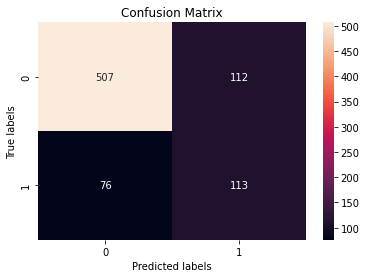

In [30]:
flashback_metrics.display_metrics()

In [57]:
with open("metrics/flashback_automatic_metrics.pkl", "wb") as f:
    pickle.dump(flashback_metrics, f)

#### Familjeliv

In [51]:
familjeliv_automatic_pipeline = pipeline(
    "text-classification",
    model="familjeliv_automatic_model",
)

loading configuration file familjeliv_automatic_model/config.json
Model config BertConfig {
  "_name_or_path": "familjeliv_automatic_model",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.2,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50325
}

loading configuration file familjeliv_automatic_model/config.json
Model config BertConfig {
  "_name_or_path": "familjeliv_automatic_model",
  "archit

In [52]:
testset = DatasetDict.load_from_disk("datasets/familjeliv_testset")["test"]
testset

Dataset({
    features: ['text', 'label'],
    num_rows: 978
})

In [53]:
familjeliv_testset_metrics = MetricsWrapper(familjeliv_automatic_pipeline, testset)

precision: 0.18
recall: 0.57
f1_score: 0.27


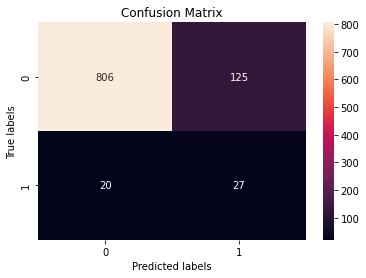

In [54]:
familjeliv_testset_metrics.display_metrics()

Then save those for drawing conclusions to be used in the discussion

In [56]:
with open("metrics/familjeliv_automatic_metrics.pkl", "wb") as f:
    pickle.dump(familjeliv_testset_metrics, f)